In [1]:
# reload
%load_ext autoreload
%autoreload 2


# First analysis of quantum processes

What do we want to do in this notebook?

1. Load data and trained models
2. Generate the belief states and activations for each model
3. Compare the belief states and activations for each model via regression
4. Compute MSE and visualize results

In [88]:
# ## Load data and trained models
# Define constants for data and sweep directories
from pathlib import Path
from glob import glob
import yaml
import json
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
from epsilon_transformers.process.GHMM import TransitionMatrixGHMM
from epsilon_transformers.process.MixedStateTree import MixedStateTree

DATA_DIR = Path("../data")
SWEEP_DIR = Path(DATA_DIR, "20241009234307")

# sweep config
with open(Path(SWEEP_DIR, "sweep_config.yaml"), 'r') as file:
    sweep_config = yaml.load(file, Loader=yaml.FullLoader)

# get all folders in the sweep directory
sweep_folders = glob(str(SWEEP_DIR / "*"))
print(sweep_config)


{'global_config': {'device': 'cuda', 'output_dir': './results', 'parallel': True, 'process_dir': './process_data', 'val_every': 1, 'wandb': True, 'wandb_project': 'quantum'}, 'model_config': {'act_fn': 'relu', 'attn_only': False, 'dtype': 'float32', 'n_ctx': 8, 'normalization_type': 'LN', 'seed': 42}, 'sweep_config': {'model_config': {'d_head': [8, 16, 32], 'n_heads': [4, 8], 'n_layers': [6, 12]}, 'process_config': [{'alpha': 2.718281828459045, 'beta': 0.5, 'name': 'post_quantum'}, {'alpha': 1.0, 'beta': 7.14142842854285, 'name': 'tom_quantum'}, {'alpha': 2000.0, 'lamb': 0.49, 'name': 'fanizza'}], 'train_config': {'batch_size': [256], 'learning_rate': [0.0001]}}, 'train_config': {'batches_per_epoch': 5000, 'bos': False, 'n_epochs': 10}}


In [76]:
sweep_folders

['../data/20241009234307/run_19_L12_H4_DH16_DM64_tom_quantum',
 '../data/20241009234307/run_20_L12_H4_DH16_DM64_fanizza',
 '../data/20241009234307/run_31_L12_H4_DH32_DM128_tom_quantum',
 '../data/20241009234307/run_18_L12_H4_DH16_DM64_post_quantum',
 '../data/20241009234307/run_0_L6_H4_DH8_DM32_post_quantum',
 '../data/20241009234307/run_6_L12_H4_DH8_DM32_post_quantum',
 '../data/20241009234307/run_34_L12_H8_DH32_DM256_tom_quantum',
 '../data/20241009234307/run_22_L12_H8_DH16_DM128_tom_quantum',
 '../data/20241009234307/run_15_L6_H8_DH16_DM128_post_quantum',
 '../data/20241009234307/run_26_L6_H4_DH32_DM128_fanizza',
 '../data/20241009234307/run_35_L12_H8_DH32_DM256_fanizza',
 '../data/20241009234307/run_27_L6_H8_DH32_DM256_post_quantum',
 '../data/20241009234307/run_9_L12_H8_DH8_DM64_post_quantum',
 '../data/20241009234307/run_14_L6_H4_DH16_DM64_fanizza',
 '../data/20241009234307/run_28_L6_H8_DH32_DM256_tom_quantum',
 '../data/20241009234307/run_12_L6_H4_DH16_DM64_post_quantum',
 '../d

In [174]:
run_folder = sweep_folders[0]
print(run_folder)

def load_model_from_run_folder(run_folder, device='cpu'):
    # run config
    with open(Path(run_folder, "run_config.yaml"), 'r') as file:
        run_config = yaml.load(file, Loader=yaml.FullLoader)

    # model config is hooked_model_config.json
    with open(Path(run_folder, "hooked_model_config.json"), 'r') as file:
        model_config = json.load(file)

    save_pts = glob(str(Path(run_folder) / "*.pt"))

    model_config['dtype'] = getattr(torch, model_config['dtype'].split('.')[-1])
    model_config['device'] = device

    model_config = HookedTransformerConfig(**model_config)

    # load the model
    model = HookedTransformer(model_config)

    return model, save_pts, run_config

# Usage:

def load_model_checkpoint(model, save_pts, idx):
    # load the last model checkpoint
    model.load_state_dict(torch.load(save_pts[idx], map_location='cpu'))
    return model

model, save_pts, run_config = load_model_from_run_folder(run_folder)
model = load_model_checkpoint(model, save_pts, -2)

../data/20241009234307/run_19_L12_H4_DH16_DM64_tom_quantum


In [175]:


#process_data = load_process_data(run_config, '../process_data')
#transformer_inputs = process_data['transformer_inputs'][:,:-1]
#print(transformer_inputs.shape)

def get_msp(run_config):
    T = get_matrix_from_args(**run_config['process_config'])
    ghmm = TransitionMatrixGHMM(T)
    ghmm.name = 'GHMM'
    msp = ghmm.derive_mixed_state_tree(depth=run_config['model_config']['n_ctx'])
    return msp

msp = get_msp(run_config)

In [176]:
from sklearn.decomposition import PCA
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = msp.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief.squeeze()) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

# now lets index each belief
msp_belief_index = {tuple(b): i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

# now lets set up all the inputs as they arrive into the transformer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == run_config['model_config']['n_ctx']]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])

transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(torch.tensor(transformer_inputs),
                                                                                                 msp_belief_index,
                                                                                                 tree_paths,
                                                                                                 tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")

from sklearn.linear_model import LinearRegression

def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions



Path: 22012103, Belief: [[0.33333333 0.17026789 0.        ]]
Path: 1303211, Belief: [[ 0.33333333  0.09492114 -0.00379685]]
Path: 13023202, Belief: [[ 0.33333333 -0.10202919  0.07627755]]
Path: 02301323, Belief: [[ 0.33333333 -0.09155677 -0.08803536]]
Path: 13023123, Belief: [[ 0.33333333 -0.09155677  0.08803536]]
Number of Unique beliefs: 13114 out of 87381
(0.33333, 0.16609, 0.09443) is indexed as 0
(0.33333, -0.08838, -0.16157) is indexed as 1
(0.33333, 0.06055, -0.13532) is indexed as 2
(0.33333, 0.01016, -0.17268) is indexed as 3
(0.33333, -0.08996, -0.11987) is indexed as 4
tensor([[2, 2, 0, 1, 2, 1, 0, 3],
        [1, 3, 0, 2, 3, 2, 0, 2],
        [0, 2, 3, 0, 1, 3, 2, 3],
        [1, 3, 0, 2, 3, 1, 2, 3],
        [0, 3, 2, 2, 2, 0, 0, 3]], dtype=torch.int32)


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_3352/4262029244.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(torch.tensor(transformer_inputs),


Transformer Input Beliefs: torch.Size([65536, 8, 3]), Transformer Input Belief Indices: torch.Size([65536, 8])


In [177]:
from tqdm.auto import tqdm
import numpy as np

def run_model_with_cache(model, transformer_inputs, batch_size=500, act_name='ln_final.hook_normalized'):
    transformer_inputs = torch.tensor(transformer_inputs)
    all_cache = {}
    
    for i in tqdm(range(0, transformer_inputs.shape[0], batch_size)):
        _, cache = model.run_with_cache(transformer_inputs[i:i+batch_size], names_filter=lambda name: act_name in name)
        if i == 0:
            keys = cache.keys()
            all_cache = {key: [] for key in keys}
        for key in keys:
            all_cache[key].append(cache[key])

    for key in keys:
        all_cache[key] = torch.cat(all_cache[key], dim=0)
    
    return all_cache

n_layers =model.cfg.n_layers
name_string = f'blocks.{n_layers-1}.hook_resid_post'
# Usage:
all_cache = run_model_with_cache(model, transformer_inputs, act_name=name_string)


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_3352/2269131509.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformer_inputs = torch.tensor(transformer_inputs)


  0%|          | 0/132 [00:00<?, ?it/s]

In [178]:
regression, belief_predictions = run_activation_to_beliefs_regression(all_cache[name_string], transformer_input_beliefs)


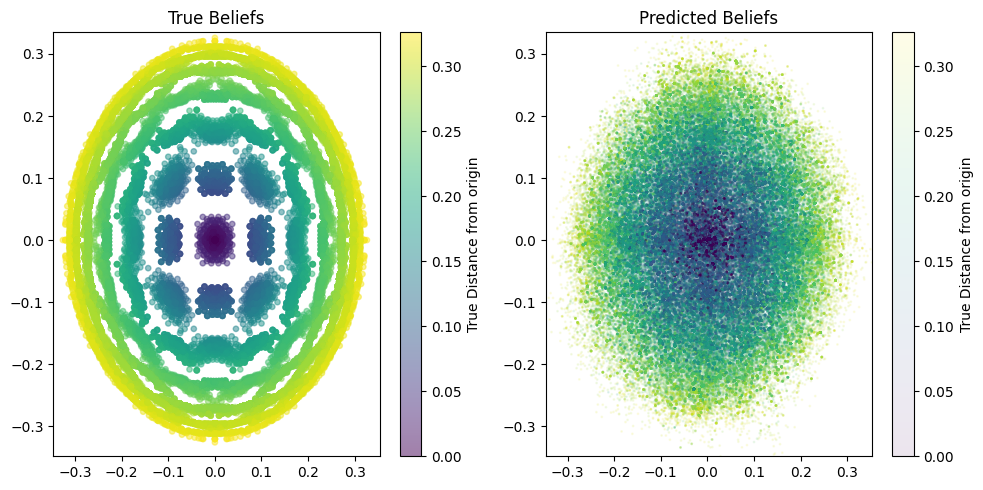

In [181]:
import matplotlib.pyplot as plt
import numpy as np

def plot_belief_predictions(belief_predictions, transformer_input_beliefs,type='tom'):
    belief_predictions_flat = belief_predictions.reshape(-1, belief_predictions.shape[-1])
    transformer_input_beliefs_flat = transformer_input_beliefs.reshape(-1, transformer_input_beliefs.shape[-1]).cpu().numpy()
    # Compute distances from origin for true beliefs
    distances = np.sqrt(np.sum(transformer_input_beliefs_flat[:, 1:]**2, axis=1))
    belief_indices = transformer_input_belief_indices.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if type == 'tom':
        inds = [1,2]
        s = [15, 1] # size of points
        alpha = [.5, .1] # transparency of points
        com = False
        c = distances
    elif type == 'fanizza':
        inds = [1,2]
        s = [15, 1]
        alpha = [.5, .1]
        com = True
        c = belief_indices.flatten()
    elif type == 'post':
        inds = [1,2]
        s = [15, 5]
        alpha = [.1, .1]
        com = False
        c = distances
    # Determine common limits
    x_min = min(transformer_input_beliefs_flat[:, inds[0]].min(), belief_predictions_flat[:, inds[0]].min())
    x_max = max(transformer_input_beliefs_flat[:, inds[0]].max(), belief_predictions_flat[:, inds[0]].max())
    y_min = min(transformer_input_beliefs_flat[:, inds[1]].min(), belief_predictions_flat[:, inds[1]].min())
    y_max = max(transformer_input_beliefs_flat[:, inds[1]].max(), belief_predictions_flat[:, inds[1]].max())
    
    # Plot true beliefs
    scatter0 = ax[0].scatter(transformer_input_beliefs_flat[:, inds[0]], transformer_input_beliefs_flat[:, inds[1]], 
                             c=c, alpha=alpha[0], s=s[0], cmap='viridis')
    ax[0].set_title('True Beliefs')
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    
    # Plot predicted beliefs
    scatter1 = ax[1].scatter(belief_predictions_flat[:, inds[0]], belief_predictions_flat[:, inds[1]], 
                             c=c, alpha=alpha[1], s=s[1], cmap='viridis')
    ax[1].set_title('Predicted Beliefs')
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    if com:
        unique_indices = set(belief_indices.flatten())
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_indices)))
        for i, color in zip(unique_indices, colors):
            com = np.mean(belief_predictions_flat[belief_indices.flatten()==i], axis=0)
            ax[1].scatter(com[inds[0]], com[inds[1]], s=s[0], alpha=1, color=color)
    
    # Add colorbars
    plt.colorbar(scatter0, ax=ax[0], label='True Distance from origin')
    plt.colorbar(scatter1, ax=ax[1], label='True Distance from origin')
    
    plt.tight_layout()
    plt.show()

plot_belief_predictions(belief_predictions, transformer_input_beliefs,type='tom')
